In [1]:
from qiskit import BasicAer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, ADAM
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import wine, iris
from qiskit.providers.aer import QasmSimulator

import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

seed = 1376
algorithm_globals.random_seed = seed

C:\Users\win10\anaconda3\envs\quantum\lib\site-packages\qiskit\__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


## Data preparation

First, we use the [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). It has $4$ features, thus needing a $4$-qubit circuit, and $3$ classes. However, we are interested in doing only a binary classification. This means that we have to eliminate a class, and we will eliminate the third class for simplicity.

In [2]:
# Use Iris data set for training and test data
feature_dim = 4  # dimension of each data point
training_size = 100
test_size = 30

# training features, training labels, test features, test labels as np.array,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = \
    iris(training_size=training_size, test_size=test_size, n=feature_dim)

In [3]:
training_features = training_features[ training_labels[:, 2]!=1 ]
training_labels = training_labels[ training_labels[:, 2]!=1, :2 ]

test_features = test_features[ test_labels[:, 2]!=1 ]
test_labels = test_labels[ test_labels[:, 2]!=1, :2 ]

## Circuit preparation

We use a ZZFeature map, with linear entanglement (i.e. only local gates), to map the data points to the quantum circuit, and then a TwoLocal ansazt as neural network, having $8$ trainable parameters.

In [8]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear', insert_barriers=True)
ansatz = TwoLocal(feature_map.num_qubits, ['ry'], 'cx', reps=1, entanglement='linear')

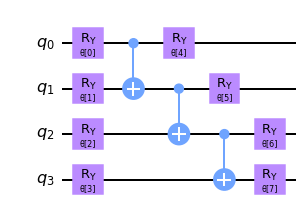

In [10]:
ansatz.draw('mpl')

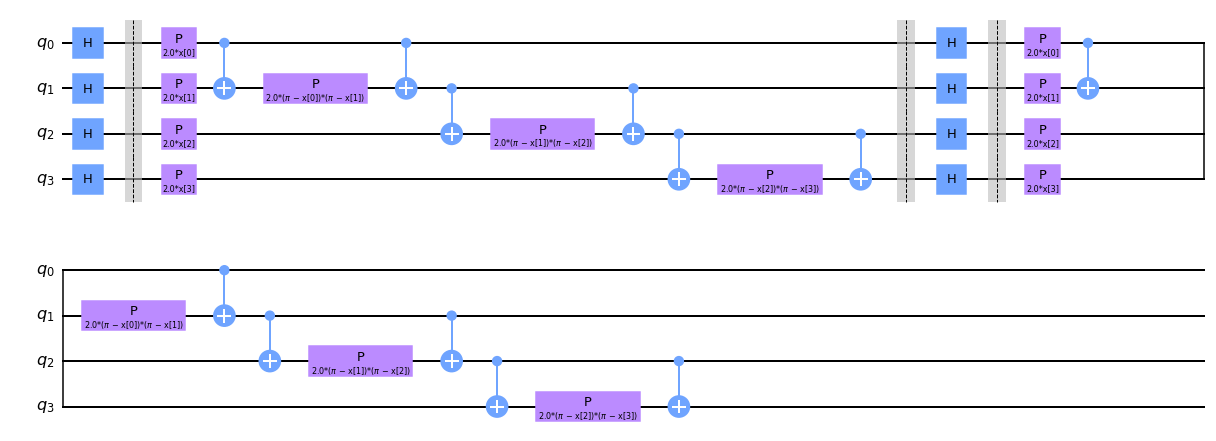

In [17]:
feature_map.draw('mpl')

## VQC optimization

Workarounds:
- **for starting with the same parameters**: the VQC class, has the attribute `_fit_result` which can be used as starting position of the optimizer if we put the `warm_start` parameter as `True`. This means that we can set the `_fit_result` prior of the optimization!
- **for monitoring the loss**: if we put the maximum number of iterations of the optimizer to $1$, or however to a small number, and then enable the `warm_start` we can access to the loss after a fit. Doing a loop over subsequent fits we can look at the evolution of the loss! *(strange behaviour)*

In [13]:
np.random.seed(123)
starting_params = np.random.uniform(-1, 1, len(ansatz.parameters))

### Statevector simulator

In [6]:
from sklearn.metrics import log_loss

In [7]:
algorithm_globals.random_seed = seed
np.random.seed(123)

loss_sv = []
n_epochs = 10
start = time()
vqc_sv = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )


vqc_sv._fit_result = [starting_params ]
 
print( 'Score before the training: {:0.2f}'.format(vqc_sv.score(training_features, training_labels) ) )
#for i in tqdm(range(n_epochs) ):
#    print(vqc_sv._fit_result)
vqc_sv.fit(training_features, training_labels)
#    loss_sv.append( log_loss(  training_labels, vqc_sv.predict(training_features) ) )
score_sv = vqc_sv.score(training_features, training_labels)
print('Score: {:0.2f}'.format(score_sv))
print('Time: {:0.2f}'.format(time()-start))

Score before the training: 0.52
Score: 0.79
Time: 225.77


### MPS simulator, bond dimension $\chi=1$

In [14]:
algorithm_globals.random_seed = seed
np.random.seed(123)

chi=1
backend = QasmSimulator(method='matrix_product_state',matrix_product_state_max_bond_dimension=chi)
start = time()

vqc_mps = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance(backend=backend,
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )

vqc_mps._fit_result = [starting_params ]
print( 'Score before the training: {:0.2f}'.format(vqc_mps.score(training_features, training_labels) ) )

vqc_mps.fit(training_features, training_labels)
score_mps = vqc_mps.score(training_features, training_labels)
print('Score: {:0.2f}'.format(score_mps))
print('Time: {:0.2f}'.format(time()-start))

Score before the training: 0.53
Score: 0.65
Time: 225.79


### MPS simulator, bond dimension $\chi=2$

In [20]:
algorithm_globals.random_seed = seed
np.random.seed(123)

chi=2
backend = QasmSimulator(method='matrix_product_state',matrix_product_state_max_bond_dimension=chi)
start = time()

vqc_mps2 = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance(backend=backend,
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )

vqc_mps2._fit_result = [starting_params ]
print( 'Score before the training: {:0.2f}'.format(vqc_mps2.score(training_features, training_labels) ) )

vqc_mps2.fit(training_features, training_labels)
score_mps2 = vqc_mps2.score(training_features, training_labels)
print('Score: {:0.2f}'.format(score_mps2))
print('Time: {:0.2f}'.format(time()-start))

Score before the training: 0.51
Score: 0.84
Time: 245.19


## Results visualization

In [10]:
# Dimensionality reduction
from sklearn.decomposition import PCA

# Dimensionality reduction
decompose = PCA(n_components=2)
decompose.fit( training_features )
X_2d = decompose.transform(training_features)

Y = np.argmax(training_labels, axis=1)

y_pred_sv = vqc_sv.predict(training_features)
y_pred_sv = np.argmax(y_pred_sv, axis=1)

y_pred_mps = vqc_mps.predict(training_features)
y_pred_mps = np.argmax(y_pred_mps, axis=1)

y_pred_mps2 = vqc_mps2.predict(training_features)
y_pred_mps2 = np.argmax(y_pred_mps2, axis=1)

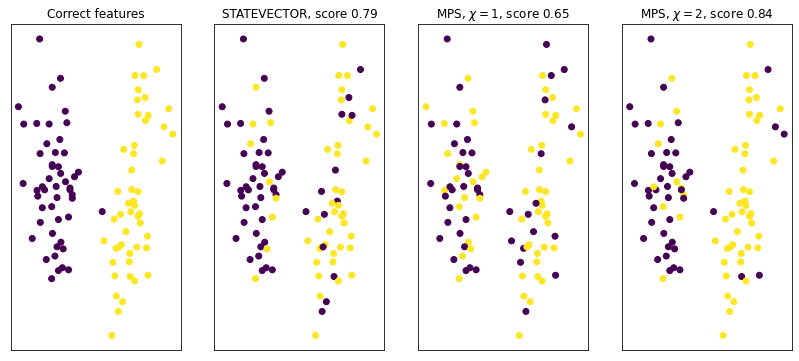

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(14, 6))
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=Y)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Correct features')


ax[1].scatter(X_2d[:, 0], X_2d[:, 1], label='Dataset', c=y_pred_sv)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f'STATEVECTOR, score {np.round(score_sv, 2)}')

ax[2].scatter(X_2d[:, 0], X_2d[:, 1], label='Dataset', c=y_pred_mps)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title(f'MPS, $\\chi=1$, score {np.round(score_mps, 2)}')

ax[3].scatter(X_2d[:, 0], X_2d[:, 1], label='Dataset', c=y_pred_mps2)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title(f'MPS, $\\chi=2$, score {np.round(score_mps2, 2)}')

#plt.savefig('res.pdf')
plt.show()

## Pretrained statevect

In [16]:
algorithm_globals.random_seed = seed

loss_sv = []
n_epochs = 10
start = time()
vqc_sv1 = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )


vqc_sv1._fit_result = vqc_mps._fit_result # MPS with chi=1
 
print( 'Score before the training: {:0.2f}'.format(vqc_sv1.score(training_features, training_labels) ) )
#for i in tqdm(range(n_epochs) ):
#    print(vqc_sv._fit_result)
vqc_sv1.fit(training_features, training_labels)
#    loss_sv.append( log_loss(  training_labels, vqc_sv.predict(training_features) ) )
score_sv1 = vqc_sv1.score(training_features, training_labels)
print('Score: {:0.2f}'.format(score_sv1))
print('Time: {:0.2f}'.format(time()-start))

Score before the training: 0.49
Score: 0.86
Time: 232.83
